## Import libraries

In [1]:
# install imbalanced-learn package
!pip install imbalanced-learn==0.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.8/24.8 MB 50.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 40.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.20.1
    Uninstalling scikit-learn-0.20.1:
      Successfully uninstalled scikit-learn-0.20.1


In [40]:
import pandas as pd
import sklearn as sk
import seaborn as sns
import imblearn
import matplotlib.pyplot as plt
import matplotlib.axes as axes

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, classification_report, precision_recall_fscore_support, confusion_matrix, precision_recall_curve, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

## Define functions

In [44]:
def grid_search_dt(X_train, y_train, metric):
    params_grid = {'max_depth': [5, 10, 20],
                   'class_weight': [{0: 0.95, 1: 0.05}, {0: 0.9, 1: 0.1}, {0: 0.8, 1: 0.2}],
                   'min_samples_split': [2, 5, 10]}
    r = 20
    dt = DecisionTreeClassifier(criterion='gini', random_state=r)
    grid_search = GridSearchCV(estimator=dt,
                               param_grid=params_grid,
                               scoring=metric,
                               cv=5,
                               verbose=3,
                               n_jobs=-2)
    grid_search.fit(X_train, y_train)
    best_est = grid_search.best_estimator_
    best_par = grid_search.best_params_
    best_score = grid_search.best_score_
    cv_results = grid_search.cv_results_
    return best_est, best_par, best_score, cv_results


def grid_search_rf(X_train, y_train, metric):
    y_train = y_train.to_numpy().ravel()
    params_grid = {'max_depth': [5, 10, 20],
                   'class_weight': [{0: 0.95, 1: 0.05}, {0: 0.9, 1: 0.1}, {0: 0.8, 1: 0.2}],
                   'n_estimators': [10, 50, 100],
                   'max_features': ['sqrt', 'log2']}
    r = 20
    rf = RandomForestClassifier(random_state=r)
    grid_search = GridSearchCV(estimator=rf, param_grid=params_grid, scoring=metric, cv=5, verbose=3, n_jobs=-2)
    grid_search.fit(X_train, y_train)
    best_est = grid_search.best_estimator_
    best_par = grid_search.best_params_
    best_score = grid_search.best_score_
    cv_results = grid_search.cv_results_
    return best_est, best_par, best_score, cv_results


def grid_search_gb(X_train, y_train, metric):
    y_train = y_train.to_numpy().ravel()
    params_grid = {'learning_rate': [0.05, 0.1, 0.5],
                   'n_estimators': [50, 100],
                   'max_depth': [10, 20],
                   'max_features': ['sqrt', 'log2'],
                   'subsample': [0.5, 1]}
    r = 20
    gb = GradientBoostingClassifier(random_state=r)
    grid_search = GridSearchCV(estimator=gb, param_grid=params_grid, scoring=metric, cv=5, verbose=3, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_est = grid_search.best_estimator_
    best_par = grid_search.best_params_
    best_score = grid_search.best_score_
    cv_results = grid_search.cv_results_
    return best_est, best_par, best_score, cv_results

## Load in dataset

In [4]:
credit_data = pd.read_csv("creditcard.csv")
credit_data.shape
#print(credit_data.head(10))

(109025, 31)

In [5]:
credit_data.isna()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109020,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
109021,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
109022,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
109023,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Drop NA values

In [1]:
credit_data.dropna(inplace=True)
credit_data.shape

NameError: name 'credit_data' is not defined

In [7]:
credit_data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,109024.000000,109024.000000,109024.000000,109024.000000,109024.000000,109024.000000,109024.000000,109024.000000,109024.000000,109024.000000,...,109024.000000,109024.000000,109024.000000,109024.000000,109024.000000,109024.000000,109024.000000,109024.000000,109024.000000,109024.000000
mean,44645.033286,-0.256874,-0.025150,0.682025,0.156140,-0.283856,0.096428,-0.115881,0.058903,-0.058147,...,-0.031439,-0.108487,-0.037077,0.010548,0.133002,0.025850,0.001697,0.001575,95.976655,0.002192
std,17910.858247,1.851924,1.646560,1.312694,1.342228,1.344998,1.297958,1.204308,1.228836,1.107862,...,0.739326,0.639778,0.625171,0.595426,0.439685,0.491488,0.392049,0.319122,259.985100,0.046770
min,0.000000,-56.407510,-72.715728,-33.680984,-5.172595,-42.147898,-26.160506,-31.764946,-73.216718,-9.283925,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.534330,-9.390980,-9.617915,0.000000,0.000000
25%,34466.000000,-1.022531,-0.594717,0.176658,-0.711430,-0.906798,-0.647205,-0.604944,-0.134457,-0.698269,...,-0.224526,-0.535608,-0.176381,-0.323376,-0.130809,-0.323685,-0.061028,-0.004984,7.000000,0.000000
50%,46486.000000,-0.260719,0.078833,0.757588,0.184481,-0.318226,-0.156138,-0.071019,0.077630,-0.124568,...,-0.057137,-0.084788,-0.049097,0.066487,0.170840,-0.068262,0.010695,0.023386,25.000000,0.000000
75%,59079.000000,1.155067,0.739991,1.382008,1.021482,0.243522,0.490659,0.410308,0.368873,0.536947,...,0.120029,0.312712,0.080875,0.407577,0.420394,0.293750,0.084706,0.076715,86.982500,0.000000
max,71184.000000,1.960497,18.902453,4.226108,16.715537,34.801666,22.529298,36.677268,20.007208,10.392889,...,27.202839,10.503090,19.002942,4.016342,5.541598,3.517346,12.152401,33.847808,19656.530000,1.000000


### Use a pairplot to see possible relationships between the data

In [8]:
sns.pairplot(credit_data, hue='Class', diag_kind='auto')

RuntimeError: Selected KDE bandwidth is 0. Cannot estimate density. Either provide the bandwidth during initialization or use an alternative method.

## Split dataset

In [8]:
X = credit_data.loc[:, credit_data.columns != 'Class']
y = credit_data.loc[:, credit_data.columns == 'Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=20)

### Balance the dataset using SMOTE

<AxesSubplot:title={'center':'SMOTE'}, xlabel='Class'>

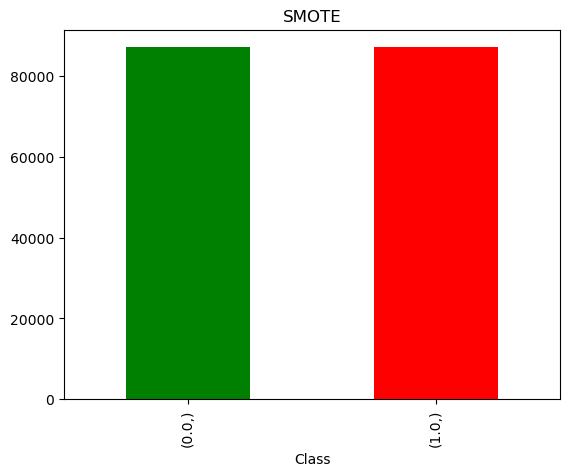

In [9]:
smote_sampler = SMOTE(random_state=20)
X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)

y_smo.value_counts().plot.bar(color=['green', 'red'], title='SMOTE')

### Balance the dataset using ADASYN

<AxesSubplot:title={'center':'ADASYN'}, xlabel='Class'>

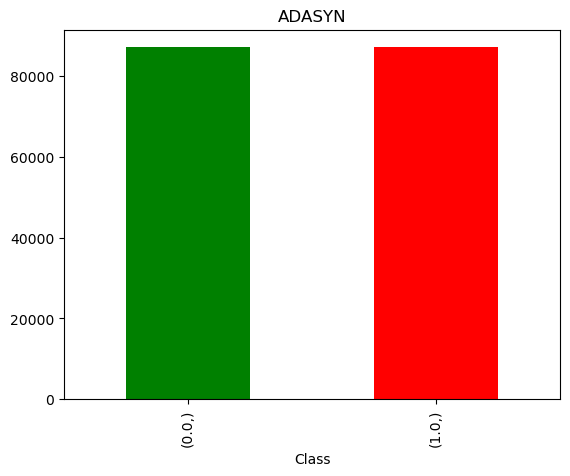

In [10]:
adasyn_sampler = ADASYN(random_state=20)
X_ada, y_ada = adasyn_sampler.fit_resample(X_train, y_train)

y_ada.value_counts().plot.bar(color=['green', 'red'], title='ADASYN')

### Balance the dataset using SMOTE-Tomek

<AxesSubplot:title={'center':'SMOTE Tomek'}, xlabel='Class'>

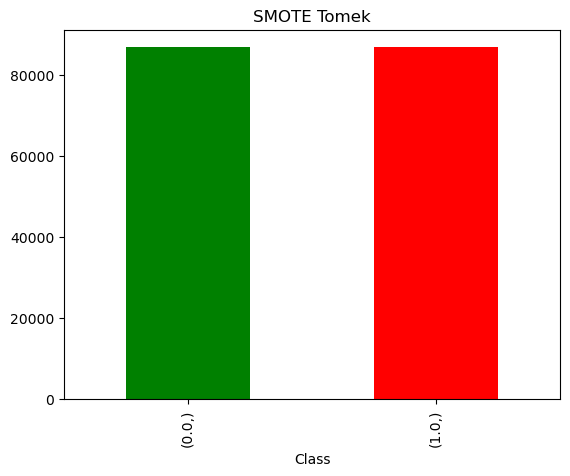

In [11]:
smote_tomek = SMOTETomek(random_state=20)
X_st, y_st = smote_tomek.fit_resample(X_train, y_train)

y_st.value_counts().plot.bar(color=['green', 'red'], title='SMOTE Tomek')

### Balance the dataset using Edited Nearest Neighbors

<AxesSubplot:title={'center':'ENN'}, xlabel='Class'>

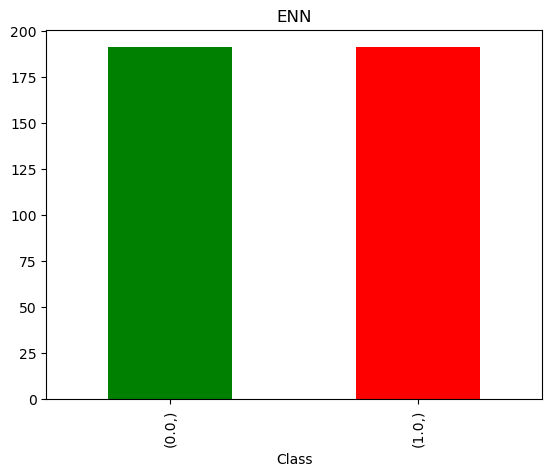

In [12]:
ru = RandomUnderSampler(sampling_strategy='auto')
X_ru, y_ru = ru.fit_resample(X_train, y_train)

y_ru.value_counts().plot.bar(color=['green', 'red'], title='ENN')

## Find the best decision tree for each training set

### Non-Balanced Data - Decision Tree

In [19]:
best_est_dt, best_par_dt, best_score_dt, cv_results_dt = grid_search_dt(X_train=X_train, y_train=y_train, metric='recall')

y_pred = best_est_dt.predict(X_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=2;, score=0.632 total time=   1.5s
[CV 2/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=2;, score=0.658 total time=   1.5s
[CV 3/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=2;, score=0.579 total time=   1.5s
[CV 4/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=2;, score=0.590 total time=   1.5s
[CV 5/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=2;, score=0.711 total time=   1.4s
[CV 1/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=5;, score=0.632 total time=   1.5s
[CV 2/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=5;, score=0.658 total time=   1.5s
[CV 3/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=5;, score=0.579 total time=   1.7s
[CV 4/5] END class_weight={0: 0.95, 1: 0.0

In [24]:
print('Recall (test) = ', recall_score(y_test, y_pred))
print('Precision (test) = ', precision_score(y_test, y_pred))

Recall (test) =  0.8541666666666666
Precision (test) =  0.8367346938775511


In [25]:
print('Recall (train) = ', best_score_dt)

Recall (train) =  0.8430499325236168


In [21]:
best_par_dt

{'class_weight': {0: 0.95, 1: 0.05}, 'max_depth': 20, 'min_samples_split': 2}

In [22]:
cv_results_dt

{'mean_fit_time': array([1.48166842, 1.75584793, 1.46947184, 3.17430987, 2.95766239,
        2.97735786, 4.15623679, 3.79798236, 3.78071918, 1.50301499,
        1.89779129, 1.55715485, 2.9689786 , 2.95077801, 2.93801265,
        3.7954422 , 3.50930109, 3.61387033, 1.50293813, 1.81688423,
        1.5146647 , 2.93603015, 2.96260371, 2.9481142 , 3.83407869,
        3.54945722, 3.51498623]),
 'std_fit_time': array([0.03428781, 0.44624859, 0.01901344, 0.37092313, 0.07866138,
        0.13458457, 0.37665802, 0.22952906, 0.29049758, 0.03145068,
        0.58400103, 0.0597886 , 0.06143816, 0.01817943, 0.05910625,
        0.39307851, 0.3793363 , 0.40963855, 0.03166167, 0.60422841,
        0.04852928, 0.06394797, 0.05084951, 0.04549779, 0.59592088,
        0.17804813, 0.16095453]),
 'mean_score_time': array([0.01294308, 0.01496544, 0.01261735, 0.0123024 , 0.0127357 ,
        0.01903238, 0.01732564, 0.01243725, 0.01413908, 0.0108736 ,
        0.01292071, 0.0117949 , 0.01314459, 0.01330733, 0.012219

### SMOTE - Decision Tree

In [26]:
best_est_dt_smo, best_par_dt_smo, best_score_dt_smo, cv_results_dt_smo = grid_search_dt(X_train=X_smo, y_train=y_smo, metric='recall')

y_pred = best_est_dt_smo.predict(X_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=2;, score=0.924 total time=   3.1s
[CV 2/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=2;, score=0.923 total time=   3.1s
[CV 3/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=2;, score=0.921 total time=   3.2s
[CV 4/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=2;, score=0.926 total time=   4.4s
[CV 5/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=2;, score=0.923 total time=   3.0s
[CV 1/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=5;, score=0.924 total time=   3.2s
[CV 2/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=5;, score=0.923 total time=   3.1s
[CV 3/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=5;, score=0.921 total time=   3.3s
[CV 4/5] END class_weight={0: 0.95, 1: 0.0

In [27]:
print('Recall (test) = ', recall_score(y_test, y_pred))
print('Precision (test) = ', precision_score(y_test, y_pred))

Recall (test) =  0.8333333333333334
Precision (test) =  0.37735849056603776


In [28]:
print('Recall (train) = ', best_score_dt_smo)

Recall (train) =  0.9991841735158669


In [29]:
best_par_dt_smo

{'class_weight': {0: 0.8, 1: 0.2}, 'max_depth': 20, 'min_samples_split': 2}

In [30]:
cv_results_dt_smo

{'mean_fit_time': array([3.35031705, 3.11473236, 3.00102386, 5.67053633, 5.46841526,
        5.45527296, 6.04567657, 5.91712732, 6.21297956, 2.98285546,
        2.93113155, 3.27344027, 5.54698701, 5.44376779, 5.71384535,
        5.89694815, 6.373103  , 6.15534558, 3.34119458, 3.03473005,
        3.19765611, 5.48542805, 5.73785071, 5.6482162 , 7.07180257,
        6.73204737, 7.04197412]),
 'std_fit_time': array([0.53422965, 0.12345643, 0.03930439, 0.27643293, 0.20784587,
        0.23329457, 0.67865947, 0.27843134, 0.66562607, 0.04523908,
        0.01198624, 0.60565993, 0.11814508, 0.1882479 , 0.6062244 ,
        0.25951267, 0.70578364, 0.23357025, 0.5439304 , 0.07719898,
        0.26731892, 0.21023759, 0.5416682 , 0.58950383, 0.69549673,
        0.24320067, 0.60688431]),
 'mean_score_time': array([0.02247658, 0.02432494, 0.02159381, 0.02765684, 0.02267542,
        0.02267981, 0.02390003, 0.02512226, 0.03049355, 0.02354698,
        0.02233734, 0.02103434, 0.02225199, 0.02207165, 0.023114

### ADASYN - Decision Tree

In [31]:
best_est_dt_ada, best_par_dt_ada, best_score_dt_ada, cv_results_dt_ada = grid_search_dt(X_train=X_ada, y_train=y_ada, metric='recall')

y_pred = best_est_dt_ada.predict(X_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=2;, score=0.903 total time=   2.9s
[CV 2/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=2;, score=0.926 total time=   2.9s
[CV 3/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=2;, score=0.914 total time=   3.0s
[CV 4/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=2;, score=0.902 total time=   3.0s
[CV 5/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=2;, score=0.958 total time=   3.1s
[CV 1/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=5;, score=0.903 total time=   3.1s
[CV 2/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=5;, score=0.926 total time=   3.0s
[CV 3/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=5;, score=0.914 total time=   3.0s
[CV 4/5] END class_weight={0: 0.95, 1: 0.0

In [32]:
print('Recall (test) = ', recall_score(y_test, y_pred))
print('Precision (test) = ', precision_score(y_test, y_pred))

Recall (test) =  0.8125
Precision (test) =  0.4148936170212766


In [33]:
print('Recall (train) = ', best_score_dt_ada)

Recall (train) =  0.9881384905214194


In [34]:
best_par_dt_ada

{'class_weight': {0: 0.8, 1: 0.2}, 'max_depth': 20, 'min_samples_split': 2}

In [35]:
cv_results_dt_ada

{'mean_fit_time': array([2.97144146, 3.03681188, 3.29859281, 5.39856782, 5.36968203,
        5.59843788, 6.10617108, 6.44962769, 6.20952125, 3.27057729,
        2.94091492, 2.93244572, 5.46461301, 5.70602932, 5.48689461,
        6.81621118, 6.41978192, 7.05605111, 2.9934906 , 3.00798059,
        3.27631955, 5.50006166, 5.43616424, 5.4114068 , 7.04995079,
        6.97618542, 7.04378514]),
 'std_fit_time': array([0.08311108, 0.07620868, 0.47338823, 0.10861374, 0.12955049,
        0.47210949, 0.42858179, 0.73234374, 0.45614489, 0.57832431,
        0.01947926, 0.01306269, 0.1297069 , 0.44234281, 0.13181707,
        0.93685453, 0.38889248, 1.07858244, 0.06218758, 0.04277743,
        0.57636364, 0.20479422, 0.17791042, 0.12726464, 0.40079029,
        0.37948061, 0.40472955]),
 'mean_score_time': array([0.02439075, 0.02416654, 0.02625728, 0.02172456, 0.02279806,
        0.02923527, 0.02269592, 0.02283845, 0.02324843, 0.02181106,
        0.02024441, 0.02068377, 0.02388692, 0.02308984, 0.022137

### SMOTE & Tomek Links - Decision Tree

In [36]:
best_est_dt_st, best_par_dt_st, best_score_dt_st, cv_results_dt_st = grid_search_dt(X_train=X_st, y_train=y_st, metric='recall')

y_pred = best_est_dt_st.predict(X_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=2;, score=0.926 total time=   3.0s
[CV 2/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=2;, score=0.925 total time=   2.9s
[CV 3/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=2;, score=0.924 total time=   2.9s
[CV 4/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=2;, score=0.927 total time=   2.9s
[CV 5/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=2;, score=0.925 total time=   2.9s
[CV 1/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=5;, score=0.926 total time=   2.9s
[CV 2/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=5;, score=0.925 total time=   2.8s
[CV 3/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=5;, score=0.924 total time=   2.9s
[CV 4/5] END class_weight={0: 0.95, 1: 0.0

In [37]:
print('Recall (test) = ', recall_score(y_test, y_pred))
print('Precision (test) = ', precision_score(y_test, y_pred))

Recall (test) =  0.8125
Precision (test) =  0.4642857142857143


In [38]:
print('Recall (train) = ', best_score_dt_st)

Recall (train) =  0.9992850214406399


In [39]:
best_par_dt_st

{'class_weight': {0: 0.8, 1: 0.2}, 'max_depth': 20, 'min_samples_split': 2}

In [40]:
cv_results_dt_st

{'mean_fit_time': array([2.89075422, 2.84785023, 2.89700904, 5.19569316, 5.17796903,
        5.20549502, 5.58959084, 5.58505111, 5.856075  , 3.1316782 ,
        3.47937632, 2.9677969 , 5.53856473, 6.06743279, 5.5411077 ,
        6.13885822, 6.02256875, 6.31873837, 2.92908483, 2.91525011,
        3.02269931, 5.75605836, 5.17310543, 5.53039556, 6.80216985,
        6.93651009, 6.67108006]),
 'std_fit_time': array([0.03617061, 0.01949748, 0.06398551, 0.07373415, 0.10112548,
        0.11347819, 0.19050226, 0.16758865, 0.25649661, 0.05541918,
        0.56542638, 0.05393597, 0.19757674, 0.42713896, 0.20897217,
        0.42687659, 0.18558695, 0.50909278, 0.09448417, 0.03511383,
        0.06533816, 0.97829861, 0.09739122, 0.33434306, 0.27454611,
        0.63373419, 0.36901814]),
 'mean_score_time': array([0.01985321, 0.02120886, 0.02039046, 0.02149496, 0.02290354,
        0.02117372, 0.02189965, 0.02358794, 0.02298107, 0.02492714,
        0.03040352, 0.02101283, 0.02354479, 0.03048463, 0.022420

### Random Undersampling - Decision Tree

In [41]:
best_est_dt_ru, best_par_dt_ru, best_score_dt_ru, cv_results_dt_ru = grid_search_dt(X_train=X_ru, y_train=y_ru, metric='recall')

y_pred = best_est_dt_ru.predict(X_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=2;, score=0.816 total time=   0.0s
[CV 2/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=2;, score=0.872 total time=   0.0s
[CV 3/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=2;, score=0.868 total time=   0.0s
[CV 4/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=2;, score=0.868 total time=   0.0s
[CV 5/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=2;, score=0.974 total time=   0.0s
[CV 1/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=5;, score=0.816 total time=   0.0s
[CV 2/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=5;, score=0.872 total time=   0.0s
[CV 3/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, min_samples_split=5;, score=0.868 total time=   0.0s
[CV 4/5] END class_weight={0: 0.95, 1: 0.0

In [42]:
print('Recall (test) = ', recall_score(y_test, y_pred))
print('Precision (test) = ', precision_score(y_test, y_pred))

Recall (test) =  0.8958333333333334
Precision (test) =  0.01895107977082415


In [43]:
print('Recall (train) = ', best_score_dt_ru)

Recall (train) =  0.9160593792172739


In [44]:
best_par_dt_ru

{'class_weight': {0: 0.9, 1: 0.1}, 'max_depth': 20, 'min_samples_split': 2}

In [45]:
cv_results_dt_ru

{'mean_fit_time': array([0.00676227, 0.00563278, 0.00768538, 0.00754085, 0.00844531,
        0.0082859 , 0.00944095, 0.01033006, 0.01062708, 0.00603418,
        0.0055738 , 0.00555692, 0.00734534, 0.00842476, 0.0090734 ,
        0.01005125, 0.01004744, 0.01082458, 0.0060957 , 0.00650439,
        0.00737557, 0.00853715, 0.00992613, 0.00713305, 0.00913811,
        0.00767031, 0.00884786]),
 'std_fit_time': array([0.00156354, 0.00013283, 0.00206246, 0.00028175, 0.00165856,
        0.00151542, 0.00081839, 0.00178317, 0.00148753, 0.00025658,
        0.00025857, 0.0003775 , 0.00015025, 0.00196408, 0.00161428,
        0.00186665, 0.00176425, 0.00295355, 0.00065072, 0.00082309,
        0.00159732, 0.00072203, 0.00384832, 0.00033978, 0.00248561,
        0.00088693, 0.00196948]),
 'mean_score_time': array([0.00234461, 0.00227318, 0.00244632, 0.00225248, 0.00226364,
        0.00223022, 0.00308671, 0.00229402, 0.00297318, 0.00335841,
        0.00217118, 0.00206752, 0.00231357, 0.00234909, 0.002490

## Find the best Random Forest for each training set

### Non-Balanced Data - Random Forest

In [54]:
best_est_rf, best_par_rf, best_score_rf, cv_results_rf = grid_search_rf(X_train=X_train, y_train=y_train, metric='recall')

y_pred = best_est_rf.predict(X_test)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=10;, score=0.605 total time=   1.7s
[CV 2/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=10;, score=0.474 total time=   1.7s
[CV 3/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=10;, score=0.632 total time=   1.6s
[CV 4/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=10;, score=0.667 total time=   1.7s
[CV 5/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=10;, score=0.684 total time=   1.6s
[CV 1/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=50;, score=0.579 total time=   9.5s
[CV 2/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=50;, score=0.474 total time=   8.0s
[CV 3/5] END class_weight={0: 0.95, 1: 0.05}, max

In [55]:
print('Recall (test) = ', recall_score(y_test, y_pred))
print('Precision (test) = ', precision_score(y_test, y_pred))

Recall (test) =  0.8333333333333334
Precision (test) =  0.9090909090909091


In [56]:
best_score_rf

0.8272604588394061

In [57]:
best_par_rf

{'class_weight': {0: 0.95, 1: 0.05},
 'max_depth': 10,
 'max_features': 'sqrt',
 'n_estimators': 10}

In [58]:
cv_results_rf

{'mean_fit_time': array([ 1.65502725,  8.34618611, 17.00051656,  1.68643656,  6.8406671 ,
        13.56368976,  3.09693341, 15.60106015, 30.53906021,  2.47817545,
        12.4896965 , 24.87851882,  4.11509676, 18.77790465, 37.47256408,
         3.23387814, 15.19154992, 31.0161232 ,  1.68236198,  8.65454698,
        16.72391949,  1.32611241,  6.90293431, 13.30002065,  3.02474666,
        15.07674971, 30.2179234 ,  2.73248677, 12.34377255, 24.62821207,
         3.63311176, 17.23242183, 35.30947738,  3.04887199, 14.36834159,
        29.17959356,  1.61693401,  7.99431634, 16.46805902,  1.28982568,
         6.43481073, 13.11212039,  3.2259603 , 14.84086356, 30.51961985,
         2.49718852, 12.19408298, 24.3956243 ,  3.90670557, 17.24386115,
        34.80003819,  2.9635777 , 13.82680316, 28.06082554]),
 'std_fit_time': array([0.02564816, 0.55920227, 0.57840056, 0.4078877 , 0.20075807,
        0.68806594, 0.0897392 , 0.5927394 , 0.63037333, 0.05603249,
        0.45551439, 0.81753145, 0.54362

### SMOTE - Random Forest

In [14]:
best_est_rf_smo, best_par_rf_smo, best_score_rf_smo, cv_results_rf_smo = grid_search_rf(X_train=X_smo, y_train=y_smo, metric='recall')

y_pred = best_est_rf_smo.predict(X_test)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=10;, score=0.899 total time=   3.1s
[CV 2/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=10;, score=0.897 total time=   3.1s
[CV 3/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=10;, score=0.897 total time=   3.1s
[CV 4/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=10;, score=0.896 total time=   3.2s
[CV 5/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=10;, score=0.893 total time=   3.1s
[CV 1/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=50;, score=0.904 total time=  16.5s
[CV 2/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=50;, score=0.901 total time=  15.4s
[CV 3/5] END class_weight={0: 0.95, 1: 0.05}, max

In [15]:
print('Recall (test) = ', recall_score(y_test, y_pred))
print('Precision (test) = ', precision_score(y_test, y_pred))

Recall (test) =  0.8541666666666666
Precision (test) =  0.8367346938775511


In [16]:
best_score_rf_smo

1.0

In [17]:
best_par_rf_smo

{'class_weight': {0: 0.9, 1: 0.1},
 'max_depth': 20,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [18]:
cv_results_rf_smo

{'mean_fit_time': array([ 3.06328001, 15.71554408, 30.99746265,  2.51280503, 12.55005584,
        25.17986374,  5.47715855, 26.32431126, 52.57228017,  4.28149543,
        21.30544567, 42.36539154,  6.57004619, 31.49197855, 62.57126231,
         5.27845988, 25.18256836, 50.53426232,  3.06512666, 15.43480525,
        31.00941834,  2.48911638, 12.53088903, 25.04842305,  5.38541884,
        26.79991665, 53.93032126,  4.37218332, 21.8330627 , 43.98110828,
         6.50212798, 30.9175271 , 62.45700498,  5.19819002, 25.28070874,
        50.59255929,  3.2536294 , 15.26622047, 30.50734816,  2.74220729,
        12.43688235, 25.04845638,  5.42404962, 27.27410283, 54.4838665 ,
         4.5740972 , 22.01461334, 44.00747085,  6.52382498, 31.17781572,
        63.59702244,  5.14860511, 25.78402228, 51.1967865 ]),
 'std_fit_time': array([0.04159469, 0.61680269, 0.73182036, 0.01478342, 0.43819341,
        0.54681376, 0.35029501, 0.76477563, 0.65502623, 0.07859335,
        0.42863202, 0.29590023, 0.39471

### ADASYN - Random Forest

In [19]:
best_est_rf_ada, best_par_rf_ada, best_score_rf_ada, cv_results_rf_ada = grid_search_rf(X_train=X_ada, y_train=y_ada, metric='recall')

y_pred = best_est_rf_ada.predict(X_test)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=10;, score=0.878 total time=   3.1s
[CV 2/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=10;, score=0.882 total time=   2.9s
[CV 3/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=10;, score=0.880 total time=   3.0s
[CV 4/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=10;, score=0.874 total time=   3.0s
[CV 5/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=10;, score=0.908 total time=   3.1s
[CV 1/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=50;, score=0.883 total time=  14.9s
[CV 2/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=50;, score=0.890 total time=  16.2s
[CV 3/5] END class_weight={0: 0.95, 1: 0.05}, max

In [20]:
print('Recall (test) = ', recall_score(y_test, y_pred))
print('Precision (test) = ', precision_score(y_test, y_pred))

Recall (test) =  0.8541666666666666
Precision (test) =  0.8367346938775511


In [21]:
best_score_rf_ada

0.9912418549072685

In [22]:
best_par_rf_ada

{'class_weight': {0: 0.8, 1: 0.2},
 'max_depth': 20,
 'max_features': 'sqrt',
 'n_estimators': 50}

In [23]:
cv_results_rf_ada

{'mean_fit_time': array([ 3.01030574, 15.12208471, 30.35705376,  2.42783666, 12.30426311,
        24.57702327,  5.02150412, 25.70290151, 51.51054711,  4.35282793,
        20.5174571 , 41.39748592,  6.0500617 , 30.20502586, 60.48066363,
         5.1805325 , 24.58977294, 49.54523277,  3.20983677, 15.09721084,
        30.03647251,  2.45283809, 12.29223166, 24.63470316,  5.46205969,
        26.36373019, 52.78591156,  4.28533549, 21.22335877, 42.3466186 ,
         6.33707981, 30.4645658 , 60.95741997,  5.16344075, 24.01774054,
        49.40721397,  3.22289672, 15.14454069, 30.07986102,  2.44312968,
        12.21646919, 24.43839445,  5.53442602, 26.75105681, 53.73929601,
         4.26698146, 21.61860585, 43.25183001,  6.11184726, 30.61293249,
        61.74646564,  5.18181853, 24.81057358, 49.76912017]),
 'std_fit_time': array([0.07656793, 0.48296361, 0.68015305, 0.01960321, 0.51247392,
        0.39940136, 0.09654094, 0.5719383 , 0.52886917, 0.48987164,
        0.59985447, 0.35938118, 0.14186

### SMOTE & Tomek Links - Random Forest

In [13]:
best_est_rf_st, best_par_rf_st, best_score_rf_st, cv_results_rf_st = grid_search_rf(X_train=X_st, y_train=y_st, metric='recall')

y_pred = best_est_rf_st.predict(X_test)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=10;, score=0.906 total time=   3.3s
[CV 2/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=10;, score=0.894 total time=   3.2s
[CV 3/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=10;, score=0.888 total time=   3.3s
[CV 4/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=10;, score=0.890 total time=   3.2s
[CV 5/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=10;, score=0.900 total time=   3.3s
[CV 1/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=50;, score=0.905 total time=  16.1s
[CV 2/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=50;, score=0.905 total time=  17.9s
[CV 3/5] END class_weight={0: 0.95, 1: 0.05}, max

In [14]:
print('Recall (test) = ', recall_score(y_test, y_pred))
print('Precision (test) = ', precision_score(y_test, y_pred))

Recall (test) =  0.875
Precision (test) =  0.84


In [15]:
best_score_rf_st

0.9999884686346864

In [16]:
best_par_rf_st

{'class_weight': {0: 0.8, 1: 0.2},
 'max_depth': 20,
 'max_features': 'sqrt',
 'n_estimators': 50}

In [17]:
cv_results_rf_st

{'mean_fit_time': array([ 3.23387465, 16.20907125, 31.90103192,  2.60337029, 13.83698015,
        26.23475065,  5.73507781, 27.66390915, 54.66027436,  4.76701584,
        21.8273006 , 44.07441683,  6.41303606, 32.28790593, 65.13639197,
         5.22236066, 26.23303676, 52.88056831,  3.21840229, 16.02851372,
        32.16432014,  2.59467044, 12.93147421, 25.86963725,  5.55765424,
        27.69439125, 55.60683637,  4.50828619, 22.59551473, 44.85733624,
         6.81917443, 32.80323548, 64.9954371 ,  5.44474959, 26.59024649,
        52.94600272,  3.48090348, 15.9168273 , 31.80559726,  2.90896173,
        13.09535933, 25.80432186,  5.67702489, 28.15985141, 56.6666091 ,
         4.52719841, 22.92822032, 46.16229692,  6.69071603, 33.57976174,
        65.8192852 ,  5.57064519, 26.97045193, 53.90361648]),
 'std_fit_time': array([0.06046816, 0.8250584 , 0.72017577, 0.032483  , 1.10037416,
        0.91069307, 0.52046429, 1.11425406, 0.4177782 , 0.65215421,
        0.55815372, 0.44587468, 0.23196

### Random Undersampling - Random Forest

In [18]:
best_est_rf_ru, best_par_rf_ru, best_score_rf_ru, cv_results_rf_ru = grid_search_rf(X_train=X_ru, y_train=y_ru, metric='recall')

y_pred = best_est_rf_ru.predict(X_test)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=10;, score=0.816 total time=   0.0s
[CV 2/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=10;, score=0.846 total time=   0.0s
[CV 3/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=10;, score=0.868 total time=   0.0s
[CV 4/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=10;, score=0.868 total time=   0.0s
[CV 5/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=10;, score=0.947 total time=   0.0s
[CV 1/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=50;, score=0.816 total time=   0.1s
[CV 2/5] END class_weight={0: 0.95, 1: 0.05}, max_depth=5, max_features=sqrt, n_estimators=50;, score=0.846 total time=   0.1s
[CV 3/5] END class_weight={0: 0.95, 1: 0.05}, max

In [19]:
print('Recall (test) = ', recall_score(y_test, y_pred))
print('Precision (test) = ', precision_score(y_test, y_pred))

Recall (test) =  0.875
Precision (test) =  0.048723897911832945


In [20]:
best_score_rf_ru

0.9109311740890688

In [21]:
best_par_rf_ru

{'class_weight': {0: 0.8, 1: 0.2},
 'max_depth': 20,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [22]:
cv_results_rf_ru

{'mean_fit_time': array([0.01792965, 0.07303114, 0.1474401 , 0.01774535, 0.07470889,
        0.13412423, 0.01876197, 0.08011761, 0.16088963, 0.01845784,
        0.07998061, 0.15521803, 0.01845026, 0.079706  , 0.16247768,
        0.01788559, 0.07226548, 0.1728456 , 0.02950969, 0.16430001,
        0.23905039, 0.01609764, 0.06894455, 0.14655843, 0.01870461,
        0.08190784, 0.15900526, 0.01893272, 0.07379541, 0.14955368,
        0.01970725, 0.08511548, 0.16935945, 0.01846499, 0.07514491,
        0.14702816, 0.0155436 , 0.0701304 , 0.14119878, 0.01650891,
        0.06903138, 0.14124584, 0.01831899, 0.07932892, 0.16192579,
        0.01678777, 0.08024745, 0.15410748, 0.02078547, 0.08294711,
        0.16275864, 0.01801414, 0.07922249, 0.15596986]),
 'std_fit_time': array([0.00475458, 0.00387274, 0.00693755, 0.00267568, 0.00414937,
        0.00511411, 0.00283735, 0.00266404, 0.01391864, 0.00255787,
        0.00896047, 0.01917616, 0.00241587, 0.00413563, 0.00870477,
        0.0023546 , 0.003

## Find the best Gradient Boosting Classifier for each training set

### Non-Balanced Data - Gradient Boosting Tree

In [45]:
best_est_gb, best_par_gb, best_score_gb, cv_results_gb = grid_search_gb(X_train=X_train, y_train=y_train, metric='recall')

y_pred = best_est_gb.predict(X_test)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END learning_rate=0.05, max_depth=10, max_features=sqrt, n_estimators=50, subsample=0.5;, score=0.684 total time=  11.5s
[CV 2/5] END learning_rate=0.05, max_depth=10, max_features=sqrt, n_estimators=50, subsample=0.5;, score=0.605 total time=  11.6s
[CV 3/5] END learning_rate=0.05, max_depth=10, max_features=sqrt, n_estimators=50, subsample=0.5;, score=0.789 total time=  11.5s
[CV 4/5] END learning_rate=0.05, max_depth=10, max_features=sqrt, n_estimators=50, subsample=0.5;, score=0.795 total time=  11.4s
[CV 5/5] END learning_rate=0.05, max_depth=10, max_features=sqrt, n_estimators=50, subsample=0.5;, score=0.842 total time=  11.8s
[CV 1/5] END learning_rate=0.05, max_depth=10, max_features=sqrt, n_estimators=50, subsample=1;, score=0.711 total time=  22.8s
[CV 2/5] END learning_rate=0.05, max_depth=10, max_features=sqrt, n_estimators=50, subsample=1;, score=0.684 total time=  21.8s
[CV 3/5] END learning_rate=0.05,

In [46]:
print('Recall = ', recall_score(y_test, y_pred))
print('Precision = ', precision_score(y_test, y_pred))

Recall =  0.8333333333333334
Precision =  0.7407407407407407


In [47]:
best_score_gb

0.7904183535762483

In [48]:
best_par_gb

{'learning_rate': 0.1,
 'max_depth': 10,
 'max_features': 'sqrt',
 'n_estimators': 50,
 'subsample': 1}

In [49]:
cv_results_gb

{'mean_fit_time': array([11.52586389, 22.42371111, 23.27856326, 45.04069567,  9.52747297,
        18.37706704, 19.45206594, 36.5070879 , 21.79412279, 26.0201827 ,
        43.83362536, 53.17002177, 17.54048185, 21.54483161, 35.87997284,
        43.2751431 , 11.77485075, 22.38700175, 23.44974685, 43.96925526,
         9.62038908, 18.29244676, 19.37234659, 36.34984908, 21.67719774,
        26.14850793, 40.05454755, 41.10893044, 17.63399553, 21.35777926,
        32.44807839, 34.24478064, 11.81566358, 16.50714445, 23.78765912,
        24.15464492,  9.55043755, 14.58294249, 19.15168953, 21.28108377,
        13.64841499,  8.78161664, 23.35515828,  8.85675855, 11.78646259,
         7.09182892, 20.20826607,  7.34996333]),
 'std_fit_time': array([0.14007713, 0.59732162, 0.56002866, 0.9774165 , 0.11295212,
        0.63209828, 0.49172849, 0.67696676, 0.58272264, 1.2491217 ,
        0.72022136, 1.98251655, 0.51516578, 1.29436411, 0.85389429,
        1.61391035, 0.4940399 , 0.66473939, 0.59540498, 0

In [58]:
cv_results_gb_frame = pd.DataFrame.from_dict(cv_results_gb)
best_results_gb_frame = cv_results_gb_frame.loc[cv_results_gb_frame['rank_test_score'] <= 3].reset_index()
best_results_gb_frame

,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_max_features,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,13,21.544832,1.294364,0.044479,0.003616,0.05,20,log2,50,1,"{'learning_rate': 0.05, 'max_depth': 20, 'max_...",0.736842,0.763158,0.763158,0.769231,0.894737,0.785425,0.055791,3
1,15,43.275143,1.613910,0.073759,0.003710,0.05,20,log2,100,1,"{'learning_rate': 0.05, 'max_depth': 20, 'max_...",0.736842,0.763158,0.763158,0.769231,0.894737,0.785425,0.055791,3
2,17,22.387002,0.664739,0.038120,0.002883,0.1,10,sqrt,50,1,"{'learning_rate': 0.1, 'max_depth': 10, 'max_f...",0.736842,0.684211,0.868421,0.820513,0.842105,0.790418,0.069010,1
3,19,43.969255,0.939376,0.063144,0.003510,0.1,10,sqrt,100,1,"{'learning_rate': 0.1, 'max_depth': 10, 'max_f...",0.736842,0.684211,0.868421,0.820513,0.842105,0.790418,0.069010,1
4,29,21.357779,1.199851,0.047682,0.010694,0.1,20,log2,50,1,"{'learning_rate': 0.1, 'max_depth': 20, 'max_f...",0.736842,0.763158,0.763158,0.769231,0.894737,0.785425,0.055791,3
5,31,34.244781,1.484634,0.061665,0.003431,0.1,20,log2,100,1,"{'learning_rate': 0.1, 'max_depth': 20, 'max_f...",0.736842,0.763158,0.763158,0.769231,0.894737,0.785425,0.055791,3
6,45,7.091829,0.674048,0.022471,0.000657,0.5,20,log2,50,1,"{'learning_rate': 0.5, 'max_depth': 20, 'max_f...",0.736842,0.763158,0.763158,0.769231,0.894737,0.785425,0.055791,3
7,47,7.349963,0.503767,0.023404,0.001817,0.5,20,log2,100,1,"{'learning_rate': 0.5, 'max_depth': 20, 'max_f...",0.736842,0.763158,0.763158,0.769231,0.894737,0.785425,0.055791,3


In [1]:
for i in range(7):
    lr = best_results_gb_frame.at[i, 'param_learning_rate']
    md = best_results_gb_frame.at[i, 'param_max_depth']
    mf = best_results_gb_frame.at[i, 'param_max_features']
    ne = best_results_gb_frame.at[i, 'param_n_estimators']
    gb = GradientBoostingClassifier(learning_rate=lr, max_depth=md, max_features=mf, n_estimators=ne, random_state=20)
    

NameError: name 'best_results_gb_frame' is not defined

### SMOTE - Gradient Boosting Tree

In [ ]:
best_est_gb_smo, best_par_gb_smo, best_score_gb_smo, cv_results_gb_smo = grid_search_gb(X_train=X_smo, y_train=y_smo, metric='recall')

y_pred = best_est_gb_smo.predict(X_test)

In [ ]:
print('Recall = ', recall_score(y_test, y_pred))
print('Precision = ', precision_score(y_test, y_pred))

In [ ]:
best_score_gb_smo

In [ ]:
best_par_gb_smo

In [ ]:
cv_results_gb_smo

### ADASYN - Gradient Boosting Tree

In [ ]:
best_gb_ada = grid_search_gb(X_train=X_ada, y_train=y_ada, metric='recall')

y_pred = best_gb_ada.predict(X_test)

print('Recall = ', recall_score(y_test, y_pred))
print('Precision = ', precision_score(y_test, y_pred))

### SMOTE & Tomek Links - Gradient Boosting Tree

In [ ]:
best_gb_st = grid_search_gb(X_train=X_st, y_train=y_st, metric='recall')

y_pred = best_gb_st.predict(X_test)

print('Recall = ', recall_score(y_test, y_pred))
print('Precision = ', precision_score(y_test, y_pred))

### Random Undersampling - Gradient Boosting Tree

In [ ]:
best_gb_ru = grid_search_gb(X_train=X_ru, y_train=y_ru, metric='recall')

y_pred = best_gb_ru.predict(X_test)

print('Recall = ', recall_score(y_test, y_pred))
print('Precision = ', precision_score(y_test, y_pred))